Report

In [1]:
library(tidyverse)
library(readr)
library(repr)
library(tidymodels)
library(readxl)
library(gridExtra)
library(RColorBrewer)
require(gridExtra)
options(repr.matrix.max..rows = 6)
set.seed(99999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
url <- "https://github.com/Adrianna-Nimmons/dsci-100-project-group51/raw/main/beans.xlsx"
download.file(url, "beans.xlsx")
beans_data <- read_excel("beans.xlsx")
beans_data <- mutate(beans_data, Class = as_factor(Class))

beans_split <- initial_split(beans_data, prop = 0.75, strata = Class)
beans_training <- training(beans_split)
beans_testing <- testing(beans_split) 


In [4]:
head(beans_training)

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
47143,858.562,296.8463,203.0587,1.461874,0.7294319,47996,244.9986,0.7179866,0.9822277,0.8036811,0.8253384,0.006296720,0.001802281,0.6811835,0.9958045,BARBUNYA
48165,824.701,310.0210,198.2600,1.563709,0.7687869,48758,247.6400,0.8069056,0.9878379,0.8899147,0.7987847,0.006436645,0.001616435,0.6380569,0.9977357,BARBUNYA
49166,856.332,293.7756,214.1689,1.371701,0.6844902,50168,250.2001,0.7759785,0.9800271,0.8425397,0.8516709,0.005975177,0.001939179,0.7253434,0.9949539,BARBUNYA
49975,873.529,313.9997,203.9383,1.539680,0.7603739,50699,252.2502,0.7147965,0.9857196,0.8230155,0.8033453,0.006283135,0.001614229,0.6453636,0.9936534,BARBUNYA
50166,893.846,313.0216,204.6558,1.529503,0.7566610,51209,252.7317,0.7625171,0.9796325,0.7890308,0.8073940,0.006239716,0.001635636,0.6518851,0.9970598,BARBUNYA
50167,873.825,309.8928,206.7724,1.498715,0.7448443,50937,252.7343,0.7945989,0.9848833,0.8256178,0.8155538,0.006177225,0.001685713,0.6651280,0.9968372,BARBUNYA


In [8]:
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune() ) |>
        set_engine("kknn") |>
        set_mode("classification")
beans_training_variables <- beans_training |>
                            select(Class,MinorAxisLength,ConvexArea,EquivDiameter,roundness,ShapeFactor1, ShapeFactor2)
knn_recipe<- recipe(Class~., data=beans_training_variables) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

kvals<-tibble(neighbors= seq(from = 2, to =20 , by= 2))
# kvals
# knn_recipe
# knn_spec
beans_vfold <- vfold_cv(beans_training_variables, v=6 , strata=Class)
knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = beans_vfold, grid = kvals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8865386,6,0.005484183,Preprocessor1_Model01
4,accuracy,multiclass,0.9064295,6,0.003310158,Preprocessor1_Model02
6,accuracy,multiclass,0.9110352,6,0.003187536,Preprocessor1_Model03
8,accuracy,multiclass,0.9122091,6,0.003471618,Preprocessor1_Model04
10,accuracy,multiclass,0.9134828,6,0.003015907,Preprocessor1_Model05
12,accuracy,multiclass,0.9156387,6,0.003113349,Preprocessor1_Model06
14,accuracy,multiclass,0.9141693,6,0.002940932,Preprocessor1_Model07
16,accuracy,multiclass,0.9137773,6,0.003608597,Preprocessor1_Model08
18,accuracy,multiclass,0.9142671,6,0.002815534,Preprocessor1_Model09


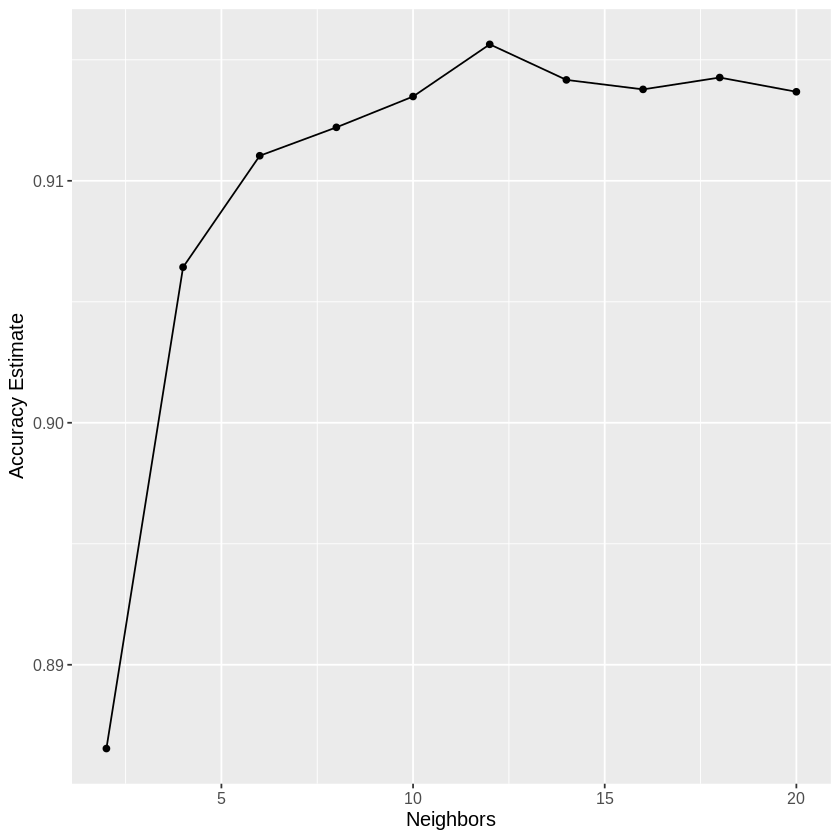

In [9]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k


In [15]:
beans_testing_variables <-  beans_testing |>
                            select(Class,MinorAxisLength,ConvexArea,EquivDiameter,roundness,ShapeFactor1, ShapeFactor2)
head(beans_testing_variables)

Class,MinorAxisLength,ConvexArea,EquivDiameter,roundness,ShapeFactor1,ShapeFactor2
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEKER,182.7344,29172,191.2728,0.8870336,0.006978659,0.003563624
SEKER,183.1571,31044,197.6597,0.9542398,0.006958910,0.003151550
SEKER,184.8749,31558,199.3211,0.9579485,0.006892534,0.003136682
SEKER,184.1634,31599,199.7422,0.9765108,0.006918465,0.003075469
SEKER,180.9171,32052,201.2536,0.9696001,0.007041108,0.002830886
SEKER,181.9409,32308,201.9704,0.9674786,0.007006752,0.002832168


In [18]:
k<-12
beans_spec <- nearest_neighbor(weight_func="rectangular", neighbors = k ) |>
        set_engine("kknn") |>
        set_mode("classification")
# beans_spec
beans_fit<-workflow()|>
            add_recipe(knn_recipe) |>
            add_model(beans_spec) |>
            fit(data=beans_training_variables)
beans_predict<- predict(beans_fit, beans_testing_variables) |>
                bind_cols(beans_testing_variables)
head(beans_predict)      


.pred_class,Class,MinorAxisLength,ConvexArea,EquivDiameter,roundness,ShapeFactor1,ShapeFactor2
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEKER,SEKER,182.7344,29172,191.2728,0.8870336,0.006978659,0.003563624
SEKER,SEKER,183.1571,31044,197.6597,0.9542398,0.006958910,0.003151550
SEKER,SEKER,184.8749,31558,199.3211,0.9579485,0.006892534,0.003136682
SEKER,SEKER,184.1634,31599,199.7422,0.9765108,0.006918465,0.003075469
SEKER,SEKER,180.9171,32052,201.2536,0.9696001,0.007041108,0.002830886
SEKER,SEKER,181.9409,32308,201.9704,0.9674786,0.007006752,0.002832168


In [22]:
accuracy<- beans_predict |>
            metrics(truth=Class, estimate=.pred_class)
accuracy
conf <- beans_predict |>
        conf_mat(truth=Class, estimate=.pred_class)
conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9162996
kap,multiclass,0.8988109


          Truth
Prediction SEKER BARBUNYA BOMBAY CALI HOROZ SIRA DERMASON
  SEKER      481        2      0    1     0    9       12
  BARBUNYA     3      292      0    8     1    1        0
  BOMBAY       0        0    128    0     0    0        0
  CALI         0       35      0  387    10    2        0
  HOROZ        0        5      0    7   465   14        3
  SIRA        14        6      0    5    11  552       57
  DERMASON    10        0      0    0     5   64      815